In [ ]:
import os
import pygame
import numpy as np
import pandas as pd

from PIL import Image
from env.pok_env_gym_RLLib import PokemonEnv

# 1. Jouer à la main et récupérer coordonnées à la main

In [2]:
from pygame.locals import QUIT, KEYDOWN, K_UP, K_DOWN, K_LEFT, K_RIGHT, K_a, K_b, K_q 

# Function to map keyboard inputs to actions
def get_action():
    for event in pygame.event.get():
        if event.type == QUIT:
            pygame.quit()
            exit()
        elif event.type == KEYDOWN:
            if event.key == K_UP:
                return 0  
            elif event.key == K_DOWN:
                return 1  
            elif event.key == K_LEFT:
                return 2  
            elif event.key == K_RIGHT:
                return 3 
            elif event.key == K_a:
                return 4  
            elif event.key == K_b:
                return 5  
            elif event.key == K_q: 
                return 7
    return 6  

In [10]:
from tqdm.notebook import tqdm
import os
import pygame
from env.pok_env_gym_RLLib import PokemonEnv
import numpy as np

screenshot_dir = "screenshots1"
if not os.path.exists(screenshot_dir):
    os.makedirs(screenshot_dir)

def play_game():
    pygame.init()
    
    env = PokemonEnv()

    env.reset()
    random = True

    for i in tqdm(range(100000)):
        
        if random: 
            action = np.random.randint(0,7)
            if i%5==0: 
                screen_image = env.pyboy.screen_image()
                screen_image.save(f"screenshots1/frame_test_{i//5}.png")
        else: 
            action = get_action()

        if action == 7 and not random: 
            random = True
        
        env.step(action)

        #print(f"Action: {action}, Reward: {reward}, Total Reward: {total_reward}")

    env.close()

    # return env.data_info
play_game()

  0%|          | 0/100000 [00:00<?, ?it/s]

In [16]:
for i in range(10): 
    data_info = play_game()
    data_info.to_csv(f"runs/data_random_{i}_30000.csv")

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

# 2. Plot maps une à côté des autres

In [3]:
from IPython.display import clear_output

def play_game_with_df():
    df_data = pd.DataFrame(columns=["m", "x", "y"])
    print(df_data)

    pygame.init()
    
    env = PokemonEnv()

    observation, info = env.reset()

    total_reward = 0
    done = False

    while not done:

        action = get_action()

        if action == 7: 
            done = True
            continue
        

        observation, reward, terminated, done, info = env.step(action)
        total_reward += reward

        m, x, y = info['coordinates']

        df_data.loc[len(df_data)+1]= [m, x, y]

        print(f"m: {m}, x: {x}, y:{y}")
        clear_output(wait=True)

        #print(f"Action: {action}, Reward: {reward}, Total Reward: {total_reward}")

    env.close()

    return df_data

In [4]:
df_data = play_game_with_df()

Pokédex: 0, Badges: 0, Death: 0, Levels: 0, exploration: 0
m: 0, x: 1, y:1


In [5]:
df_data.to_csv("./data_test.csv")

# 3. Afficher coordonnées endroits visités

In [2]:
df_data = pd.read_csv("./data_coords_test.csv")

In [26]:
import subprocess

screenshots_dir = "gan/screenshots/"

def extract_number(filename:str):
    parts = filename.split(".")[0].split("_")
    for part in parts:
        if part.isdigit():
            return int(part)
    return None

list_number_used = []
for file in os.listdir(screenshots_dir): 
    if "test_" in file: 
        command_test = ["cp", os.path.join(screenshots_dir, file), os.path.join(screenshots_dir, "test", file)]
        subprocess.run(command_test)
        number = extract_number(file)
        list_number_used.append(number)
        file_train = f"frame_train_{number}.png"
        command_train = ["cp", os.path.join(screenshots_dir, file_train), os.path.join(screenshots_dir, "test", file_train)]
        subprocess.run(command_train)
    if "train_" in file: 
        number = extract_number(file)
        if not number in list_number_used: 
            command_train = ["cp", os.path.join(screenshots_dir, file), os.path.join(screenshots_dir, "train", file)]
            subprocess.run(command_train)

In [27]:
for file in os.listdir(screenshots_dir):
    if file.endswith(".png"): 
        command = ['rm', os.path.join(screenshots_dir, file)]
        subprocess.run(command)

In [5]:
import random
import subprocess

screenshots_dir_train = os.path.join(screenshots_dir, "train")

for file in os.listdir(screenshots_dir_train):
    if file.endswith('.png'):
        if random.random() < 0.15:
            command_val = ["cp", os.path.join(screenshots_dir_train, file), os.path.join(screenshots_dir_train, "val", file)] 
            subprocess.run(command_val)
        else: 
            command_train = ["cp", os.path.join(screenshots_dir_train, file), os.path.join(screenshots_dir_train, "train", file)] 
            subprocess.run(command_train)

In [6]:
for file in os.listdir(screenshots_dir_train):
    if file.endswith(".png"): 
        command = ['rm', os.path.join(screenshots_dir_train, file)]
        subprocess.run(command)

In [3]:
def make_all_coords_arrays(df):
    return np.array(df[['x', 'y', 'm']].to_numpy().astype(np.uint8))

def game_coord_to_pixel_coord(
    x, y, map_idx, base_y):
    
    global_offset = np.array([1056-16*12, 331]) #np.array([790, -29])
    map_offsets = {
        0: np.array([0,0]), # pallet town
        1: np.array([-10, 72]), # viridian
        2: np.array([-10, 180]), # pewter
        12: np.array([0, 36]), # route 1
        13: np.array([0, 144]), # route 2
        14: np.array([30, 172]), # Route 3
        15: np.array([80, 190]), #Route 4
        33: np.array([-50, 64]), # route 22
        37: np.array([-9, 2]), # red house first
        38: np.array([-9, 25-32]), # red house second
        39: np.array([9+12, 2]), # blues house
        40: np.array([25-4, -6]), # oaks lab
        41: np.array([30, 47]), # Pokémon Center (Viridian City)
        42: np.array([30, 55]), # Poké Mart (Viridian City)
        43: np.array([30, 72]), # School (Viridian City)
        44: np.array([30, 64]), # House 1 (Viridian City)
        47: np.array([21,136]), # Gate (Viridian City/Pewter City) (Route 2)
        49: np.array([21,108]), # Gate (Route 2)
        50: np.array([21,108]), # Gate (Route 2/Viridian Forest) (Route 2)
        51: np.array([-35, 137]), # viridian forest
        52: np.array([-10, 189]), # Pewter Museum (floor 1)
        53: np.array([-10, 198]), # Pewter Museum (floor 2)
        54: np.array([-21, 169]), #Pokémon Gym (Pewter City)
        55: np.array([-19, 177]), #House with disobedient Nidoran♂ (Pewter City)
        56: np.array([-30, 163]), #Poké Mart (Pewter City)
        57: np.array([-19, 177]), #House with two Trainers (Pewter City)
        58: np.array([-25, 154]), # Pokémon Center (Pewter City)
        59: np.array([83, 227]), # Mt. Moon (Route 3 entrance)
        60: np.array([123, 227]), # Mt. Moon
        61: np.array([152, 227]), # Mt. Moon
        68: np.array([65, 190]), # Pokémon Center (Route 4)
        193: None # Badges check gate (Route 22)
    }
    if map_idx in map_offsets.keys():
        offset = map_offsets[map_idx]
    else:
        offset = np.array([0,0])
        x, y = 0, 0
    coord = global_offset + 16*(offset + np.array([x,y]))
    coord[1] = base_y - coord[1]
    return coord

def blend_overlay(background, over):
    al = over[...,3].reshape(over.shape[0], over.shape[1], 1)
    ba = (255-al)/255
    oa = al/255
    return (background[..., :3]*ba + over[..., :3]*oa).astype(np.uint8)

In [4]:
base_coords = make_all_coords_arrays(df_data)

main_map = np.array(Image.open('pokemap_full_bw.png'))
start_bg = main_map.copy()
overlay = np.zeros_like(start_bg, dtype=np.uint8)

In [9]:
pixel_coords = np.zeros((base_coords.shape[0], 2))

for i, row in enumerate(base_coords):
    x, y, m = row
    x_img, y_img = game_coord_to_pixel_coord(x, y, m, overlay.shape[1])
    pixel_coords[i,:] = np.array([x_img, y_img]).astype(int)

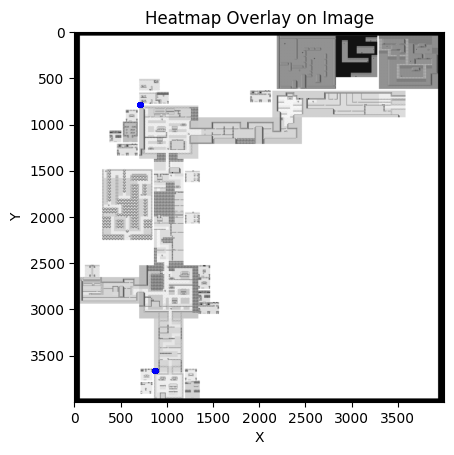

In [10]:
import numpy as np
import matplotlib.pyplot as plt

img_width = 4000
img_height = 4000

# # Define the grid
# x_min, x_max = 0, img_width
# y_min, y_max = 0, img_height
# bin_size = 10
# xx, yy = np.meshgrid(np.arange(x_min, x_max, bin_size),
#                      np.arange(y_min, y_max, bin_size))

# xedges_flat = np.sort(xx.ravel())
# yedges_flat = np.sort(yy.ravel())

plt.imshow(main_map, cmap='gray')
# heatmap, xedges, yedges = np.histogram2d(pixel_coords[:, 0], pixel_coords[:, 1], bins=(xedges_flat, yedges_flat))
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Plot the heatmap overlaying the image
# plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', alpha=0.5)
# plt.colorbar(label='Density')
plt.scatter(pixel_coords[:, 0], pixel_coords[:, 1], s=2, color='blue', alpha=0.5)  # Plot the original points
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap Overlay on Image')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,20))
plt.imshow(img_full)

In [ ]:
base_coords = make_all_coords_arrays(df_data)
base_coords

In [19]:
n = base_coords.shape[0]
game_coords = np.zeros((n,2))

for i in range(n): 
    x, y, m = base_coords[i,:]
    x_pix, y_pix = game_coord_to_pixel_coord(x, y, m, 0)
    game_coords[i,:] = [x_pix, y_pix]
    

# 4. Plot distribution des états visités 3D

# 5. Plot distribution des états visités 2D